In [1]:
import dbscan
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
from matplotlib import image as image
import cv2
import pandas
import matplotlib.patches as patches
import random
%matplotlib inline

./images/test/image_people_154.png


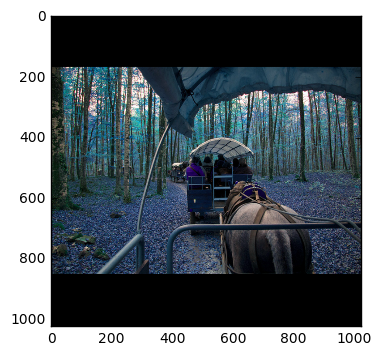

In [2]:
#Can change
IMG_DIRECTORY = "./images/test/"
list_of_images = os.listdir(IMG_DIRECTORY)
rand = random.randint(0, len(list_of_images)-1)
IMG_PATH = IMG_DIRECTORY + list_of_images[rand]
#show the image
img = cv2.imread(IMG_PATH)
print(IMG_PATH)
plt.imshow(img)

n_clusters 613
Number of clusters:  613


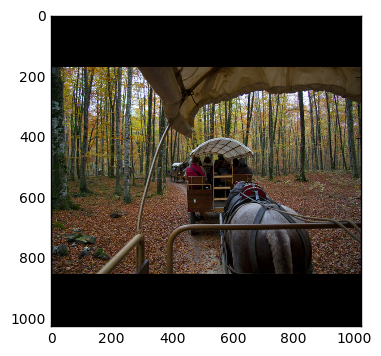

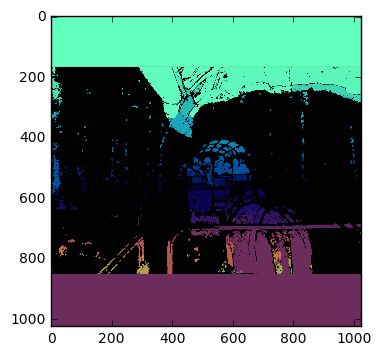

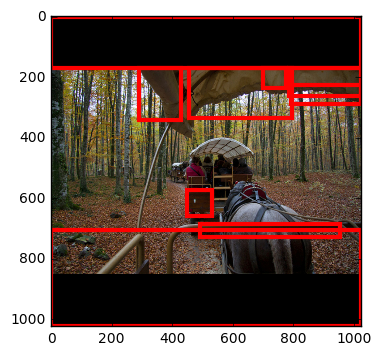

In [3]:
lab_img = dbscan.downsample_to_lab(img, 0)
labels = dbscan.sklearn_dbscan(lab_img, 4.5, 17)
bbs = dbscan.get_bounding_boxes(labels, top=10)
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB))
dbscan.view_dbscan(labels)

dbscan.view_bbs(lab_img, bbs)

In [4]:
def crop_image(bb, image):
    crop_image = image[bb[0][0]:bb[2][0], bb[0][1]:bb[1][1], :]
    return crop_image
    

In [5]:
#now set up the model
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

Using TensorFlow backend.


In [6]:
sys.path.append(ROOT_DIR+"/samples/coco")
import coco
config = coco.CocoConfig()
COCO_DIR = os.path.join(ROOT_DIR, "images")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [9]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights  /Users/sunandiyer/Documents/CV/submission/Mask_RCNN/mask_rcnn_coco.h5


In [11]:
def get_mask_r_cnn_detections(image,model, class_names):
    

    results = model.detect([image], verbose=1)
    ax = get_ax(1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'], ax=ax,
                                title="Predictions")
    output = []
    for val in r['class_ids']:
        output.append(class_names[val])
    return output

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


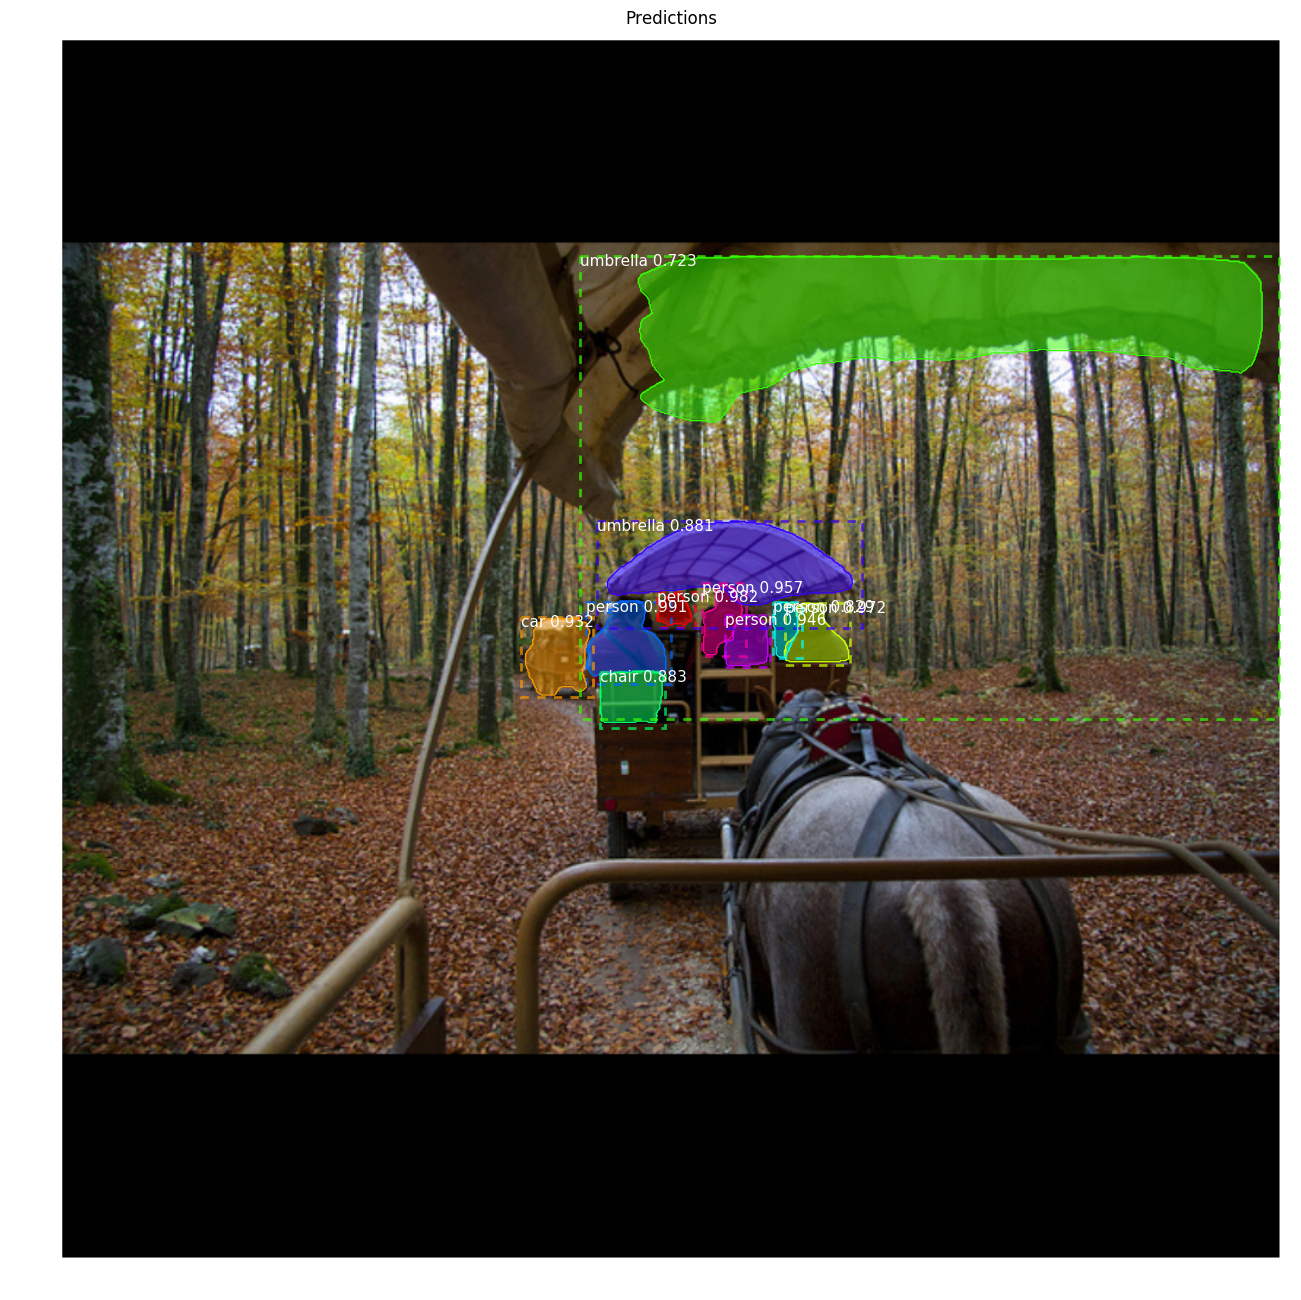

In [12]:
output_mask_rcnn = get_mask_r_cnn_detections(cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB), model, class_names)

In [13]:
#get class names
output_mask_rcnn

['person',
 'person',
 'person',
 'person',
 'person',
 'car',
 'chair',
 'umbrella',
 'person',
 'umbrella']

In [14]:
def detect_dbscan(image, model, class_names):
    results = model.detect([image], verbose=1)
    
    r = results[0]
    output = []
    for val in r['class_ids']:
        output.append(class_names[val])
    return output

In [15]:
#Now get our predicted labels
output_dbscan = []
for bb in bbs[:-1]:
    new_img = cv2.cvtColor(crop_image(bb,lab_img), cv2.COLOR_LAB2RGB)
    output_dbscan.extend(detect_dbscan(new_img, model, class_names))

Processing 1 images
image                    shape: (65, 78, 3)           min:   15.00000  max:  106.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  -18.70000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (44, 461, 3)          min:    0.00000  max:  212.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  106.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (63, 231, 3)          min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.1

In [16]:
output_dbscan

['tv', 'tie', 'tie', 'couch', 'umbrella']